In [2]:
import Pkg; Pkg.activate("C:/Users/s151781/.julia/environments/GN")
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using Distributions
using GaussianMixtures
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/preprocessing.jl")
;

Activating new environment at `C:\Users\s151781\.julia\environments\GN\Project.toml`


In [3]:
# signal preprocessing
sound_file = "../data/woman.wav"     # specify sound location
fs_desired = 8000                     # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
μ = 255                               # specify parameter for μ-law companding and expansion
nr_freqs = 32                         # specify number of Fourier coefficients
pole_location = 0.4092                # specify pole location of warped filter bank (fs=8000: ~4092, fs=16000: ~0.5756)
step_size = 4                         # specify desired stepsize (currently trade-off between step size and distortion) TODO: ask Tanya, Bert or Joris
;

In [29]:
# load signals
x, fs = wavread(sound_file, format="native")
fs = Int(fs)
x = convert(Array{Float64,1}, squeeze(x[:,1]))[1*fs:4*fs]

# preprocess signals
y = resample(x, fs_desired/fs)
y = normalize(y, normalization_method)
#y1 = μ_law_companding(y1i, μ)
yf = warp_fft(y, pole_location, nr_freqs, step_size=step_size)
yi = log.(abs.(yf))

# show segments of data
audioplayers(normalize(x, "max"), fs=fs)

<source src="data:audio/wav;base64,UklGRkDuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQTuAgC7wzW+hPtRvnu0Xr5+VFG+tRw1vvaSJ74mZBG+FyL0vYog5b1T2sO93dBpvaZ7/Lux6z4937G/Pej4Bz6AXzo+yppdPk6Yhz6taJ8+OcKxPrnNwj73o8I+oDHAPjEjuz6VM7g+LXSwPjC8nz5aPF8+Ke3iPZ6PIT01/gW97fc0vfneGr2qyi293Q2cvcsBI740w4K+/vKUvjYilL4ndYG+qh4tvoLZ8b1jAY+9V7ONvUzMp73ENGe9qWMSva0txrkqKhU9FMOOPQzjtj3RlYc9BqcsPYszBD2OkS07UJLSvKBKY73IeKe9sNykvZYHy714K+O9Yfb7vRMfFr5LZTe+hPtRvu1iVr7C0VG+Gi0yvktOFb7X+/q9EBTYvTo+wb1nb7i9lGN9veAFkLznYyk9vJXyPexmMT4aFmY+bSuEPiBnkD42Y6A+vb2uPhc3vz4iNcc+oInDPi8rxT49cbw+VP6mPpoMgj7/RBE+lA+BPa56ILtoBEK98zcavU4BJL1gYZy9V5wWvtONfL5nspy+QXifvgvpkr50vWS+oxARvj3es70dNJW9Ek2vvfcQur3Baou95ukYvYNe8zuNaIA9use7PcYVvT2wspE9slJaPQanLD2kc6o84PIavFzg07yF4Cm9pi6WvcGYz72Rx+W93qL7vdP4HL6bMDm+7rJPvg32Ur69ekq+JSs6voItG773ewW+V0jtvYMSyb3dpoC9ZuYNvDIGaD04xAk+v5xVPls2gj5MoJE+5e+hPhsnqz6U474++1LNPomk1T58Bts+WmTGPnmQpz46qWI+8g3dPfpYKz2BalI8vLsGPLPiTDt5kii9FBvmvY/5Wb54/6G+CgC1vlccrL7OCom+FO1Mvq4OGb6zEfe9ZooKvu3kGL4AKhS+dSTVvZHHD71Cxhc9KIbHPY82DD5dLPY9use7PfbmfD2mQeE8jNenPCkAgjwL5xE97QoqPaMMjzzJN8S8KumxvWwxC76I6z2+3Q1HvkIeRL7Dui++VfwjvqFwHr7Znx2+8TsgvhnGFr7SkQG+KYKWvaTTL7y2WZI91LMMPpwCSz7FWng+Lq2HPl3tlj7N+5s+hI6vPsRzxz7VGNA+UsXPPnufvz4rZZg++RtOPp4kqz03HLo8FVNXO2hADjvhDCY8o7wRvTul3L2NqWC+ikynvuTFt76J/K2+wRSLvraDUL4JiCm+fIYavsQKKb5pqDq+jSsjvh3J9L1Qz1q95c79O+IjRD0qv549F8qcPVFJlT3pMWA9bVccPQbktDxdDdQ7jkXZO38iizy9D6081iVAPFt5uLwG/629YOMJvsQKKb7fRh6+TgH6vXn9nr22GC+9mNUrvZ/jR73bAjO908s/u8hOlD0kljA+Il+GPowtpj68FbI+vBWyPgGTsj4szLM+7U23PkkAnz6pt2c+LI0qPmUMzj0ecZ09xa6hPYwBOz2k0y+8jifzvR8Cd77XaJ6+IeWiviV9i75uFmS+gkQ9vojrPb4Er1++IFJwvpinaL519ju+WYHEvR7zsbzOYAs9HnGdPWtMsz001Mg9i13tPYIW+j0qVP49QSLKPVfwlT1akIg9TkKHPZFvjj182m89UYbzPMimFb385f69Cz8+vnZdV76/ykO+uQwhviNdA74uWwu+21YyvuwSXb6l9Wm+sSxJvkGgBr5EgVm9XudpPNAuQj2aHXM9lxaPPX1BtT3JtQQ+hgY7PrdVYj7xJoE+KAaHPmHdgj6Py2s+/8JOPlMuQz6hQjA+37EUPh4G/T3Wasw9FMOOPaPPBj1zmyq8Hckevdcpab3p9IG9+xNtvXLvgr3kG7i9Khf2vZPSI75kUTO++OIgvgQaAL5lz8W9p5Wxvf23ur1o1tO9rwrpvTH3zb0aV3C9NiiZvMlwIzzI9pI8EOsqu0Pdtbz6RTa94hBPvTfMPL0dyR69ByXmvJj/vryMsb28venCvB7zsbwgrnO8TXLtuqMMjzzER1w93BHNPVa3Ez4AE0g+V5xsPrhPhT5MSI4+mxuaPi7EqT59l7U+tHa7PkIJpT7fL1I+AfzQPUN9MDzHaY284QwmPGzwAD3KxMk8jrx8vXn9Sb4ISaC+vou6vrwsqb5MM26+DHgVvrKq2710KAW+SMVEvihJar66il6+mBIJvoBjvLwOHI49z1wFPismDz6qcgE+GZjTPVYe2j27Fwo+RXkmPkbgQT4t9EU+8b04PtwRIj4mTfA9VOmHPY0+wzx0Fbu8B/tSvQBYrb3DOMK9QOXBvVro370pBAS+ntArvlq6Rr4n4k6+NIBJvr+zIb5yhOK9c1aevcQ0Z731QoO9kTKGvSvlVr2pYxK9hd7dOjwfFz01poQ9F8qcPY7PcT1ElE49ThQZPfNKDz2Lmh89no8hPYXzHj2Cvvg8vLsGPNS3jrywcS69pvFjvYCgRL10UkO91PQWvfvW5Lz71uS85ukYvXmSKL0Rex29PAwivZduEL1ERNG8iuOGvK56ILujHwQ8g17zO09kFjwSa5U7yDCuux9ufrtAb4S7ox8EPFo4hzzJcCM81kuqOzWuCLzi08a8nRURvYsgD70Uc+e81tlrvAR2A7yNBWS8sDSmvLyCp7yY7Em8EmuVO8j2kjyPDPo8W2IaPeBVDT358Q89Z7AbPeIjRD0OHGQ9iChxPQoVgD2LyI09F2OBPbj5Wj1byTU9VLsZPb9E/zw3HLo8K864PKRzqjz8dl88yrAYO3VpYbypYxK9ScE+vZk8R71ctkC9gKBEvRNJVL1jxFy9EeaTvc8fqL020Je9zriMvQ4Jb70lPla97l5QvSU+Vr2HrmC9qzFJvaQjLb0psAS97bqsvKTmpLwSpbC84AWQvL49abwqobi7nmHbOSHu6DtFS2c8XudpPOH5sDxRhvM8q0Q+Pblgdj1U6Yc9O02FPWA3iT2pC5E9Kr+ePbQguz3gGNs908rZPVMXzD1iBcA9YZ6kPVfwlT1Lomo9H6pKPXoMOT1mSQA9+S6YPNPLP7sTDMy8sHEuvaMniL3rwri9Cm3XvV3v7b1nnfy90VT6vcUG+b1/Of+98dQEvkBQDb591hO+DxgIvoog5b00l8C9ef2evThwir2aCn69aWtdvRLiOL1dR++8XM1evEm/8jrJcCM8ctSJPGZJAD0d3BM9hlo6PQcOSD3jil89jWiAPXYzmT2xgMg9CxH7PR/YDT7kCBw+28EoPgQDND46kkA+OUJHPu4dRj4Dszo+sYAdPgVq+j3lWMA9JBiePeOKiT3cfEM9dUP3u468fL2yqtu92u8WvhzNJL6sbia+MBIgvri8J75ObEW+pkVjvib5cL7Phm6+nudNvqxuJr71Kwy+PqzqvbWx6b3Ipuu9tErOvepbnb36RTa9+Rxfu4twjDya8988HdwTPWEJGz0r+Es9jWiAPW3spT3KHMs97GbcPRr/7j2wR/E9pMsAPkPCET6K9iY+uI45Pux9Uz5Y7GU+Sf5xPr+zdz5y2GE+3sg2Pjjb1j2+oFs9eD4CPSw11DzK7lw9+yZiPVo4hzw+2li9LAsSvmW4Tr6300m+aEEfvkDlwb27w4q9xz/QvceqG77usk+++wBRvkIHIr43N7O9NiiZvJosvzspxyK8ML4gvWJdQb34oZK8o88GPQncqD1IMOY9aRPcPUwJsD0IdWM91tVCPfA/fD3aQ5Y95PGkPWbeiT2vHQg9vf1zu7xYFL0XIh692psXvXgrDb1VqCS90YJovcLRpr2o/My9wZjPvShJv70JBry9GPSvvfACnr2w3KS9iOuSvQGRhL245mW9SFojvQTGAL2LSqK8+I4dvKahZryNBWS8OEp2vIBQR7xxp4m7eg6FunS1NTy8qJE8doNsPNkzbDu8S

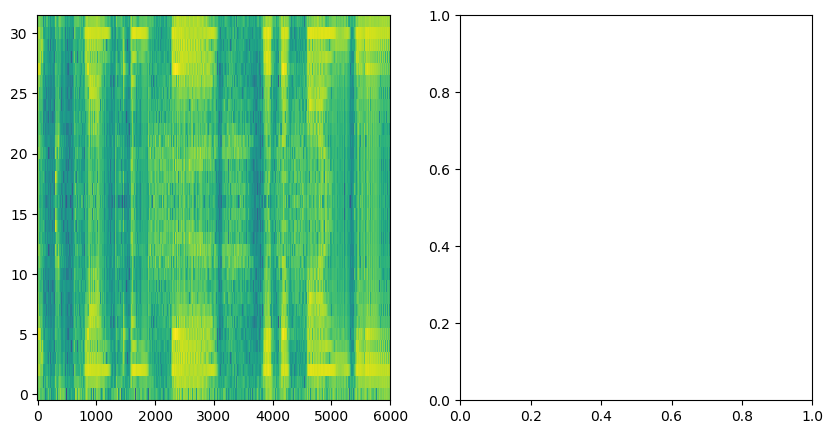

In [5]:
_, ax= plt.subplots(ncols=2, figsize=(10,5))
ax[1].imshow(yi', aspect="auto", origin="lower")
;

In [6]:
g = GMM(2, yi, kind=:diag)
p = GMMprior(g.d, 0.1, 1.0)  ## set α0=0.1 and β0=1, and other values to a default
v = VGMM(g, p) ## initialize variational GMM v with g
em!(v, yi)


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.740502e+05
      1       7.944822e+04      -9.460195e+04 |        2
      2       7.313137e+04      -6.316849e+03 |        2
      3       7.241752e+04      -7.138539e+02 |        2
      4       7.229542e+04      -1.221017e+02 |        2
      5       7.228841e+04      -7.007620e+00 |        0
      6       7.228841e+04       0.000000e+00 |        0
K-means converged with 6 iterations (objv = 72288.40923519881)

┌ Info: Initializing GMM, 2 Gaussians diag covariance 32 dimensions using 5992 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78


┌ Info: K-means with 2000 data points using 6 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = lowerbound(::VGMM{Float64}, ::Array{Float64,1}, ::Array{Float64,2}, ::Array{Array{Float64,2},1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64) at bayes.jl:221
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\bayes.jl:221
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = lowerbound(::VGMM{Float64}, ::Array{Float64,1}, ::Array{Float64,2}, ::Array{Array{Float64,2},1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64) at bayes.jl:221
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\bayes.jl:221
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = _broadcast_getindex_eval

12-element Array{Float64,1}:
 -1.451942174589342  
  0.41150847387518563
  0.41273931765408467
  0.4133567752711486 
  0.41469893227159815
  0.4188098732996662 
  0.43889837737857823
  0.5093580560747847 
  0.5421127985725654 
  0.5569211223061937 
  0.5569221654351895 
  0.5569221654351895 

In [7]:
using ForneyLab

In [15]:
exp_br(x::Array{Float64}) = exp.(x)
log_br(x::Array{Float64}) = log.(x)

log_br (generic function with 1 method)

In [36]:
fg = FactorGraph()
@RV p ~ ForneyLab.Beta(1,1)
@RV z ~ ForneyLab.Bernoulli(p)
@RV x ~ GaussianMixture(z, constant(means(g)[1,:]), constant(inv(diagm(g.Σ[1,:]))), constant(means(g)[2,:]), constant(inv(diagm(g.Σ[2,:]))))
#@RV xe ~ Nonlinear(x, g=exp_br, dims=(32,))
@RV xe
Nonlinear(x, xe, g=log_br, g_inv=exp_br, dims=(32,))
@RV y ~ GaussianMeanVariance(xe, 1e-5*Ic(32))
placeholder(y, :y, dims=(32,))
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11694725370078891550 -->
 11694725370078891550 
 
 clamp_7 
 
<!-- 6196481650882781435 -->
 6196481650882781435 
 
 Nonlinear{Unscented} 
 nonlinear_1 
 
<!-- 18079725973882470288 -->
 18079725973882470288 
 
 GM 
 gaussianmixture_1 
 
<!-- 6196481650882781435--18079725973882470288 -->
 6196481650882781435--18079725973882470288 
 
 x 
 1 out 
 1 out 
 
<!-- 5420440900332623691 -->
 5420440900332623691 
 
 Beta 
 beta_1 
 
<!-- 5762997778430605173 -->
 5762997778430605173 
 
 clamp_2 
 
<!-- 5420440900332623691--5762997778430605173 -->
 5420440900332623691--5762997778430605173 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 17497614570711380352 -->
 17497614570711380352 
 
 clamp_1 
 
<!-- 5420440900332623691--17497614570711380352 -->
 5420440900332623691--17497614570711380352 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 9062203627902411846 -->
 9062203627902411846 
 
 Ber 
 bernoulli_1 
 
<!-- 9062203627902411846--5420440900332623691 -->
 9062203627902411846--5420440900332623691 
 
 p 
 1 out 
 2 p 
 
<!-- 13788133658516293844 -->
 13788133658516293844 
 
 clamp_6 
 
<!-- 6698250188440331174 -->
 6698250188440331174 
 
 clamp_3 
 
<!-- 15856483413371467293 -->
 15856483413371467293 
 
 clamp_5 
 
<!-- 9965801948014721784 -->
 9965801948014721784 
 
 placeholder_y 
 
<!-- 7365582934058868194 -->
 7365582934058868194 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 9965801948014721784--7365582934058868194 -->
 9965801948014721784--7365582934058868194 
 
 y 
 1 out 
 1 out 
 
<!-- 18079725973882470288--9062203627902411846 -->
 18079725973882470288--9062203627902411846 
 
 z 
 1 out 
 2 z 
 
<!-- 18079725973882470288--13788133658516293844 -->
 18079725973882470288--13788133658516293844 
 
 clamp_6 
 1 out 
 6 w2 
 
<!-- 18079725973882470288--6698250188440331174 -->
 18079725973882470288--6698250188440331174 
 
 clamp_3 
 1 out 
 3 m1 
 
<!-- 18079725973882470288--15856483413371467293 -->
 18079725973882470288--15856483413371467293 
 
 clamp_5 
 1 out 
 5 m2 
 
<!-- 9974853436977570148 -->
 9974853436977570148 
 
 clamp_4 
 
<!-- 18079725973882470288--9974853436977570148 -->
 18079725973882470288--9974853436977570148 
 
 clamp_4 
 1 out 
 4 w1 
 
<!-- 7365582934058868194--11694725370078891550 -->
 7365582934058868194--11694725370078891550 
 
 clamp_7 
 1 out 
 3 v 
 
<!-- 7365582934058868194--6196481650882781435 -->
 7365582934058868194--6196481650882781435 
 
 xe 
 2 in1 
 2 m

In [37]:
algo = variationalAlgorithm([xe, x], z, p, ids=[:x, :z, :p], free_energy=true)
source_code = algorithmSourceCode(algo, free_energy=true);
source_code = compatibility_fix(source_code)
eval(Meta.parse(source_code));
#println(source_code)
;

In [38]:
# Prepare posterior factors
marginals = Dict(:p => vague(ForneyLab.Beta),
                 :z => vague(ForneyLab.Bernoulli),
                 :x => ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=ones(32), v=1e-2*Ic(32)),
                 :xe => ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=ones(32), v=1e-2*Ic(32)))

x_pred = Array{Float64,1}[]
z_pred = Float64[]
#messages = initex1()
    F = Float64[]

# loop through samples
@showprogress 1 "Processing..." for k in 1:size(yi, 1)
    
    # update data dictionary
    data = Dict(:y => (exp.(yi[k,:])))

    # Execute algorithm
    n_its = 2
    for i = 1:n_its
        #stepxe!(data, marginals)
        stepx!(data, marginals)
        stepz!(data, marginals)
        stepp!(data, marginals)
        
        # Store variational free energy for visualization
        push!(F, freeEnergy(data, marginals))
    end
    
    # save separated signals
    push!(x_pred, ForneyLab.unsafeMean(marginals[:x]))
    push!(z_pred, marginals[:z].params[:p])
end

x_pred = collect(hcat(x_pred...)')
;

Processing...100%|██████████████████████████████████████| Time: 0:00:49


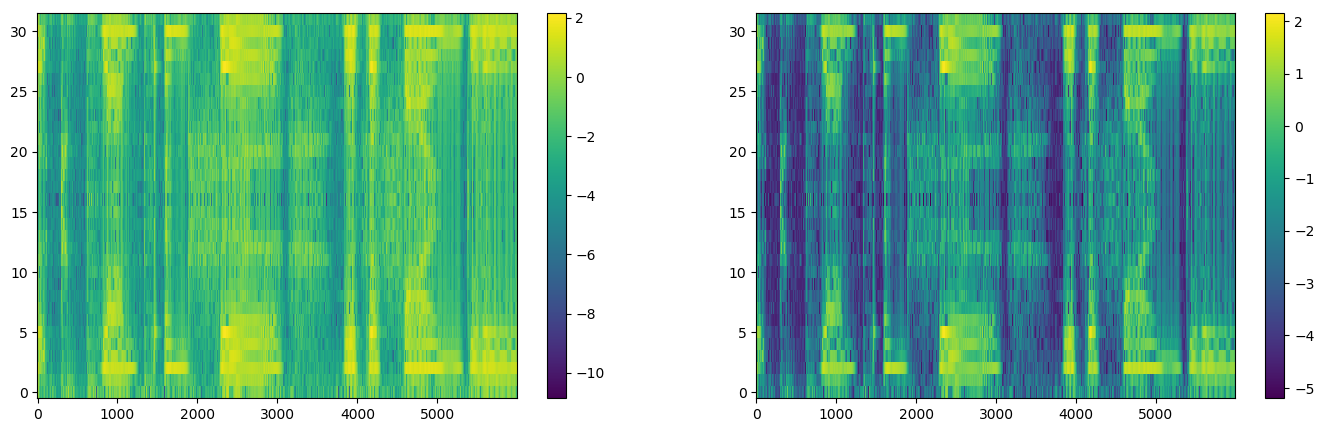

In [39]:
fig, ax= plt.subplots(ncols=2, figsize=(17,5))
pcm = ax[1].imshow(yi', aspect="auto", origin="lower")
fig.colorbar(pcm, ax=ax[1])
pcm = ax[2].imshow(x_pred', aspect="auto", origin="lower")
fig.colorbar(pcm, ax=ax[2])
;

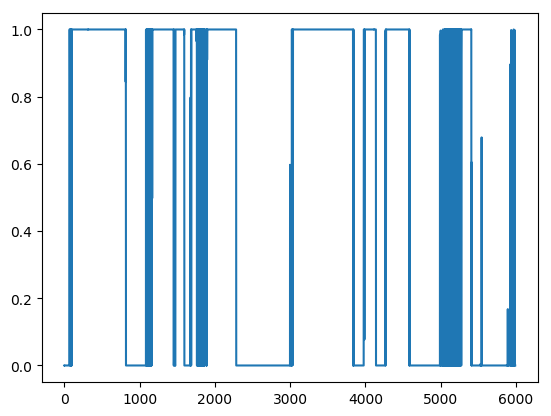

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000064437A90>

In [40]:
plt.plot(z_pred)

In [41]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
x_predi = exp.(x_pred).*exp.(1im*angle.(yf))
y_pred = warp_ifft(x_predi, pole_location, step_size)
ax[1].plot(y_pred, label="predicted")
ax[1].plot(y, label="true")
ax[2].plot(y_pred, label="predicted")
ax[2].plot(y, label="true")
ax[1].grid(), ax[2].grid(), ax[2].set_xlim(11000, 11200), ax[1].legend(), ax[2].legend()
audioplayers(y_pred, y, fs=fs_desired)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\s151781\.julia\packages\PyCall\zqDXB\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'RuntimeError'>
RuntimeError('Julia exception: MethodError: no method matching iterate(::Variable)\nClosest candidates are:\n  iterate(!Matched::Core.SimpleVector) at essentials.jl:600\n  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:600\n  iterate(!Matched::ExponentialBackOff) at error.jl:218\n  ...\nStacktrace:\n [1] jlwrap_iterator(::Variable) at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\pyiterator.jl:144\n [2] pyjlwrap_getiter(::Ptr{PyCall.PyObject_struct}) at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\pyiterator.jl:125\n [3] macro expansion at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\exception.jl:93 [inlined]\n [4] #110 at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\pyfncall.jl:43 [inlined]\n [5] disable_sigint at .\\c.jl:446 [inlined]\n [6] __pycall! at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\pyfncall.jl:42 [inlined]\n [7] _pycall!(::PyCall.PyObject, ::PyCall.PyObject, ::Tuple{Variable}, ::Int64, ::PyCall.PyObject) at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\pyfncall.jl:29\n [8] _pycall!(::PyCall.PyObject, ::PyCall.PyObject, ::Tuple{Variable}, ::Base.Iterators.Pairs{Symbol,String,Tuple{Symbol},NamedTuple{(:label,),Tuple{String}}}) at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\pyfncall.jl:11\n [9] #_#117 at C:\\Users\\s151781\\.julia\\packages\\PyCall\\zqDXB\\src\\pyfncall.jl:86 [inlined]\n [10] (::Core.var"#kw#Any")(::NamedTuple{(:label,),Tuple{String}}, ::PyCall.PyObject, ::Variable) at .\\none:0\n [11] top-level scope at In[41]:5\n [12] eval at .\\boot.jl:330 [inlined]\n [13] softscope_include_string(::Module, ::String, ::String) at C:\\Users\\s151781\\.julia\\packages\\SoftGlobalScope\\cSbw5\\src\\SoftGlobalScope.jl:218\n [14] execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\\Users\\s151781\\.julia\\packages\\IJulia\\DrVMH\\src\\execute_request.jl:67\n [15] #invokelatest#1 at .\\essentials.jl:709 [inlined]\n [16] invokelatest at .\\essentials.jl:708 [inlined]\n [17] eventloop(::ZMQ.Socket) at C:\\Users\\s151781\\.julia\\packages\\IJulia\\DrVMH\\src\\eventloop.jl:8\n [18] (::IJulia.var"#15#18")() at .\\task.jl:333',)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\__init__.py", line 1810, in inner
    return func(ax, *args, **kwargs)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 1611, in plot
    for line in self._get_lines(*args, **kwargs):
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 393, in _grab_next_args
    yield from self._plot_args(this, kwargs)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 370, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 205, in _xy_from_xy
    by = self.axes.yaxis.update_units(y)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\axis.py", line 1467, in update_units
    converter = munits.registry.get_converter(data)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\units.py", line 181, in get_converter
    converter = self.get_converter(next_item)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\units.py", line 187, in get_converter
    thisx = safe_first_element(x)
  File "C:\Users\s151781\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py", line 1637, in safe_first_element
    return next(iter(obj))
